In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch import optim

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

---
**Classifier**

In [ ]:
wine = datasets.load_wine()
data = wine.data
target = wine.target

In [ ]:
print(data.shape, target.shape)
print(wine.feature_names,'\n', wine.target_names)

(178, 13) (178,)
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'] 
 ['class_0' 'class_1' 'class_2']


In [ ]:
class WineClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WineClassifier, self).__init__()
        self.hidden  = nn.Linear(input_size, hidden_size)
        self.relu    = nn.ReLU()
        self.output  = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()

    def forward(self, X):
        feature = self.relu(self.hidden(X))
        output  = self.softmax(self.output(feature))
        return output

In [ ]:
input_size  = data.shape[1]
hidden_size = 32
output_size = len(wine.target_names)

In [ ]:
net = WineClassifier(input_size, hidden_size, output_size).to(device)
print(net)

WineClassifier(
  (hidden): Linear(in_features=13, out_features=32, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=32, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
Xtns = torch.from_numpy(data).float().to(device)
Ytns = torch.from_numpy(target).to(device)

In [ ]:
pred = net(Xtns)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
loss = criterion(pred, Ytns)
loss

tensor(1.1526, device='cuda:0', grad_fn=<NllLossBackward0>)

---
**Regression**

In [ ]:
diabetes = datasets.load_diabetes()
data = diabetes.data
target = diabetes.target

In [ ]:
class DiabetesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DiabetesRegression, self).__init__()
        self.hidden  = nn.Linear(input_size, hidden_size)
        self.relu    = nn.ReLU()
        self.output  = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X):
        feature = self.relu(self.hidden(X))
        output  = self.softmax(self.output(feature))
        return output

In [ ]:
input_size  = data.shape[1]
hidden_size = 32
output_size = 1

In [ ]:
net = DiabetesRegression(input_size, hidden_size, output_size).to(device)
net

DiabetesRegression(
  (hidden): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
criterion = nn.MSELoss().to(device)

In [ ]:
Xtns = torch.from_numpy(data).float().to(device)
Ytns = torch.from_numpy(target).float().to(device)

In [ ]:
pred = net(Xtns)

In [ ]:
loss = criterion(pred.squeeze(), Ytns)
loss.data

tensor(28771.2168, device='cuda:0')

---
**Optimization**

In [ ]:
features = [0, 9]

wine = datasets.load_wine()
data = wine.data[:, features]
targets = wine.target

Text(0, 0.5, 'alcohol')

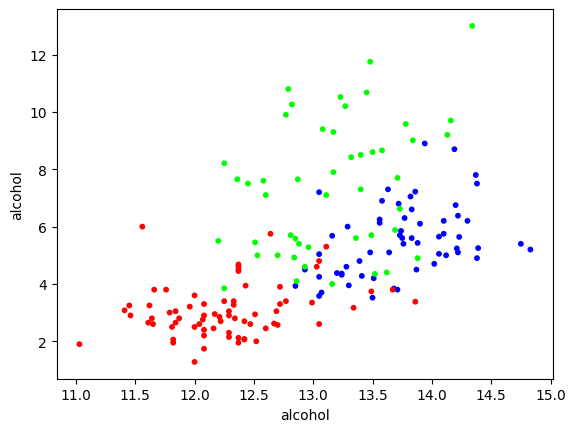

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=targets, s=10, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[0]])

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

Text(0, 0.5, 'alcohol')

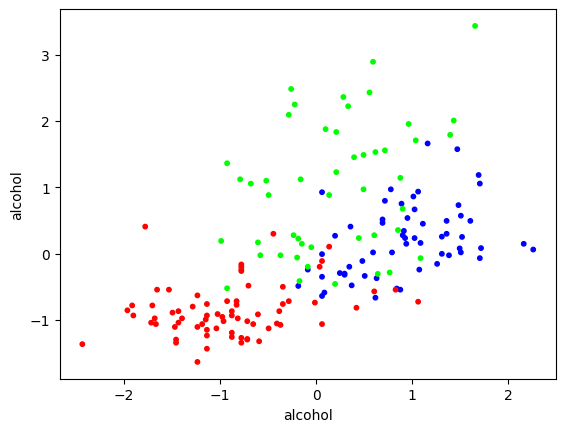

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=targets, s=10, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[0]])

In [ ]:
input_size = data.shape[1]
hidden_size = 32
output_size = len(wine.target_names)

In [ ]:
net = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Softmax()
).to(device)

In [ ]:
def plot_boundary(X, y, model):
  x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
  y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

  spacing = min(x_max - x_min, y_max - y_min) / 100

  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))

  data = np.hstack((XX.ravel().reshape(-1,1),
                    YY.ravel().reshape(-1,1)))

  # For binary problems
  # db_prob = model(Variable(torch.Tensor(data)).cuda() )
  # clf = np.where(db_prob.cpu().data < 0.5,0,1)

  # For multi-class problems
  db_prob = model(torch.Tensor(data).to(device) )
  clf = np.argmax(db_prob.cpu().data.numpy(), axis=-1)

  Z = clf.reshape(XX.shape)

  plt.contourf(XX, YY, Z, cmap=plt.cm.brg, alpha=0.5)
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=15, cmap=plt.cm.brg)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


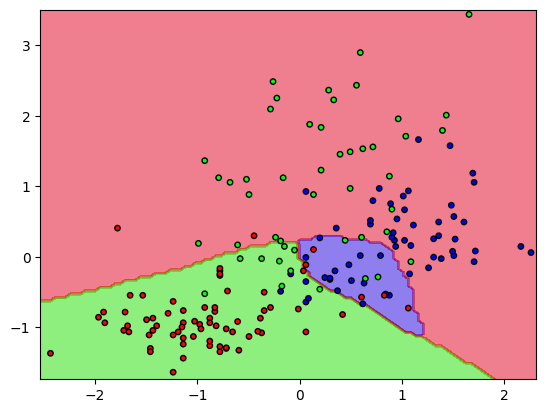

In [ ]:
plot_boundary(data, targets, net)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
X = torch.FloatTensor(data).to(device)
y = torch.LongTensor(targets).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


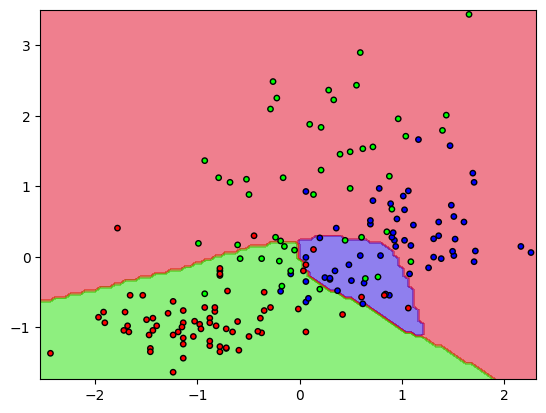

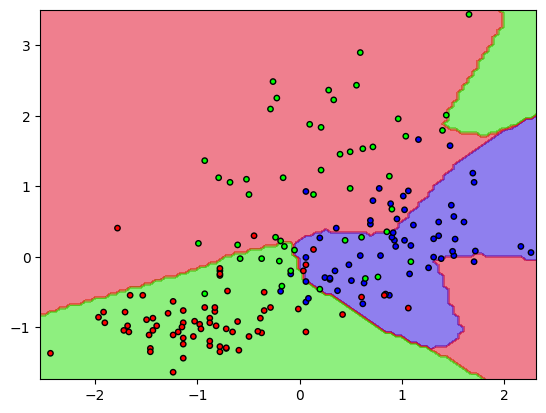

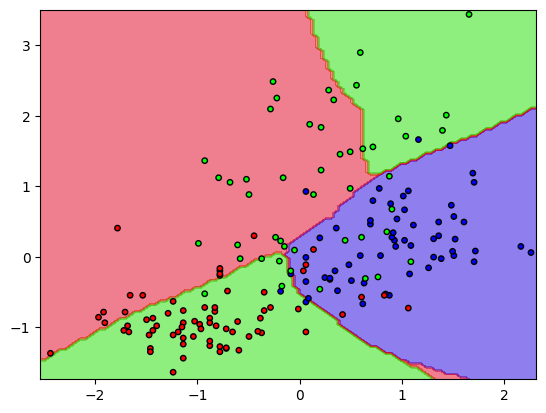

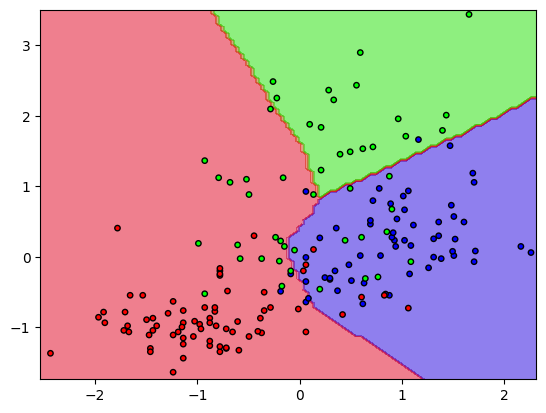

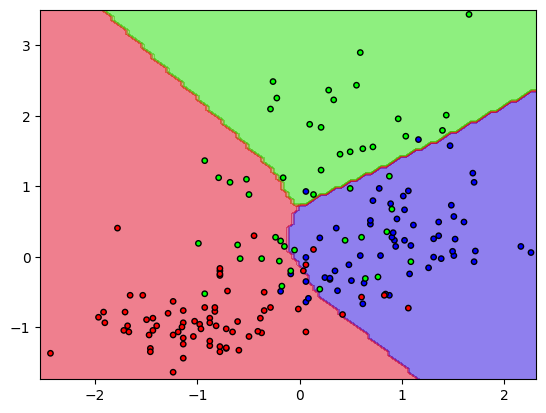

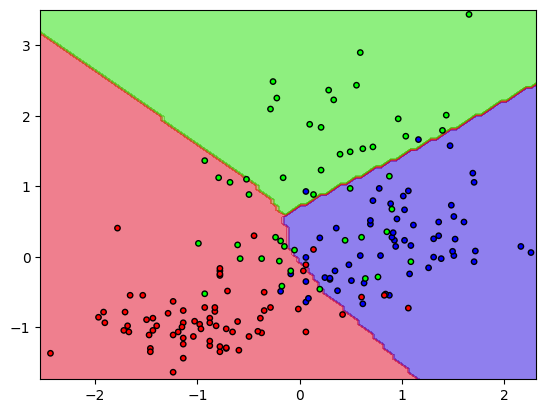

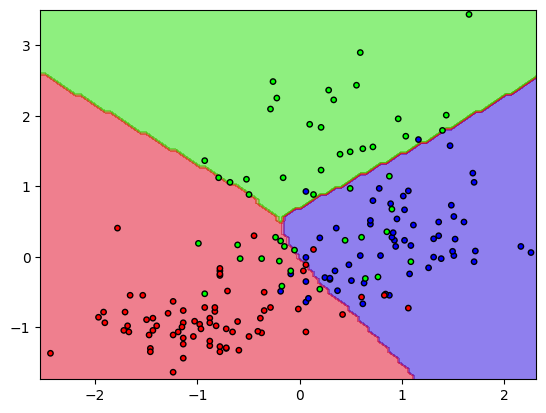

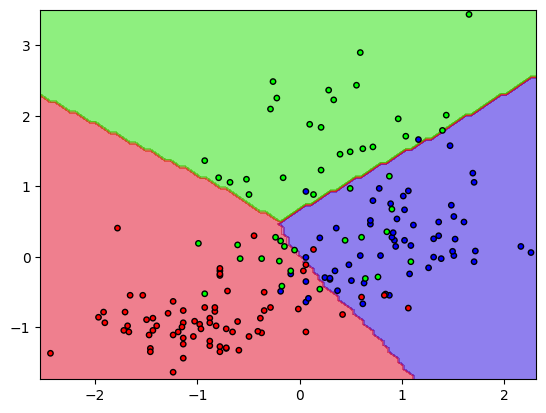

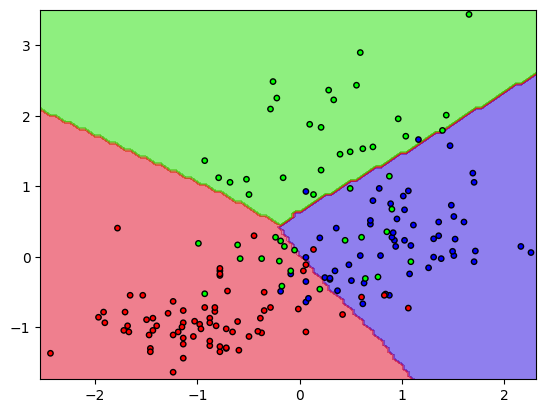

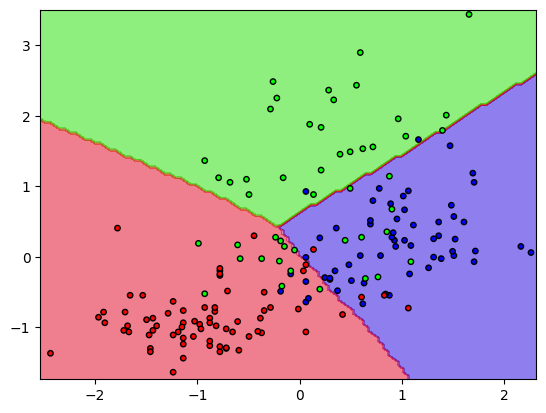

In [ ]:
for i in range(100):
    pred = net(X)
    loss = criterion(pred, y)

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        plt.figure()
        plot_boundary(data, targets, net)

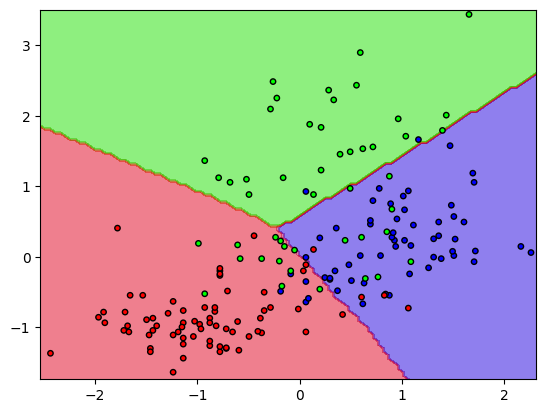

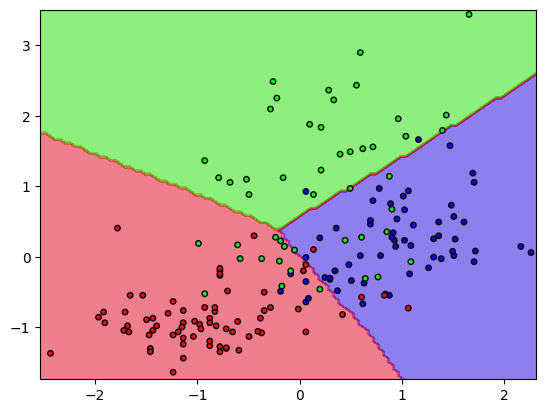

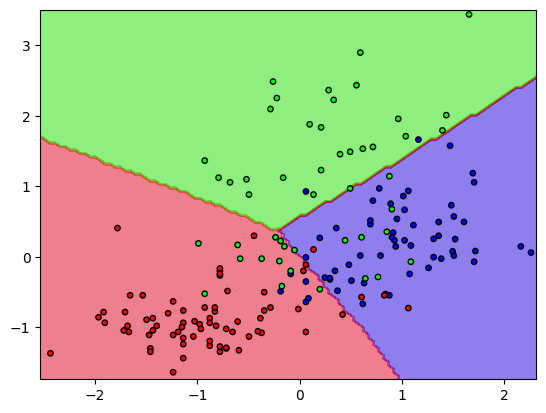

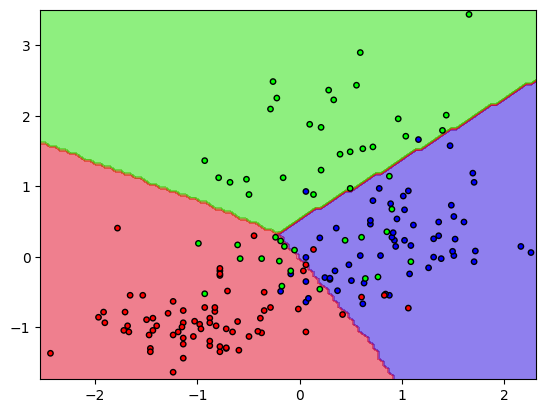

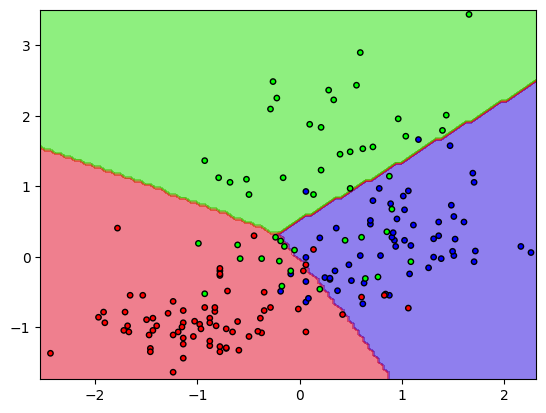

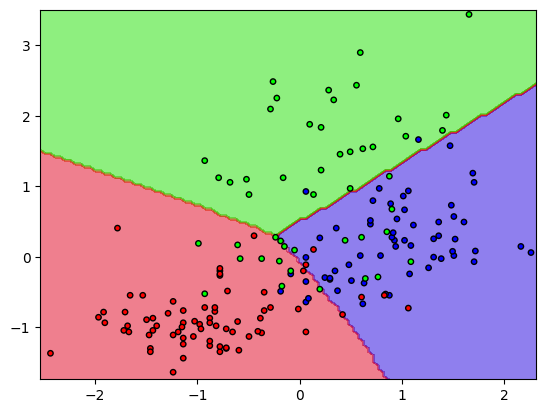

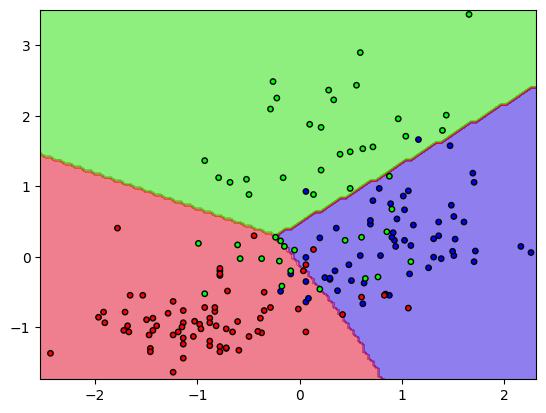

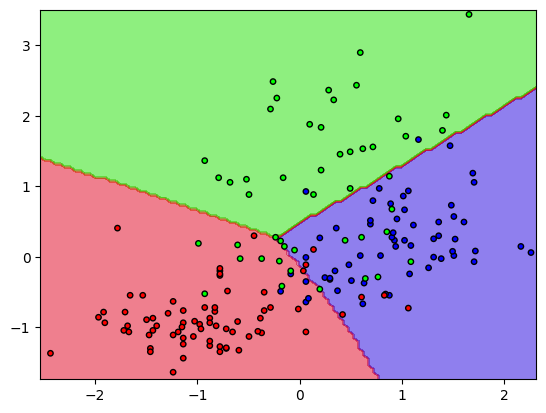

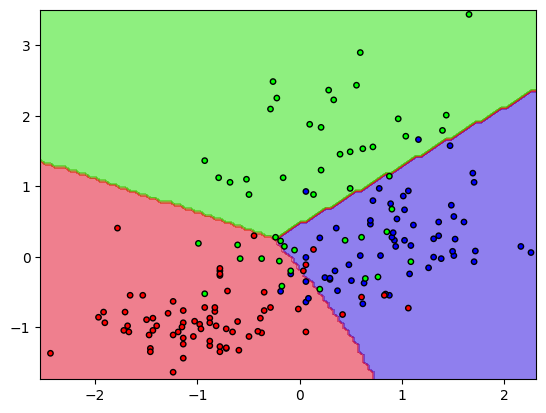

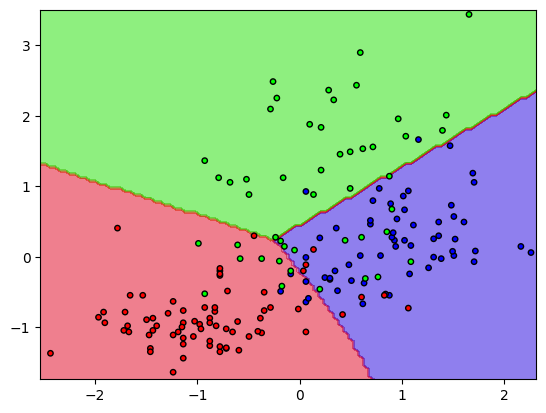

In [ ]:
for i in range(100):
    pred = net(X)
    loss = criterion(pred, y)

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        plt.figure()
        plot_boundary(data, targets, net)